Reproduce the 12Z z500 anomaly maps for each WT 

In [28]:
import datetime
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd
import xarray as xr
import matplotlib.pyplot as plt
import glob 
import os.path
import cartopy 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

casper_2020

In [36]:
level_s = np.array([0, 1, 2.5, 5, 7.5, 10, 15, 20,25, 37.5, 50,
         75, 100, 125, 150, 200, 250, 300, 400, 500, 600, 750])

proj = ccrs.PlateCarree()

def ax_coastlines_country(ax_s):
    ax_s.coastlines(linewidths=0.5)
    ax_s.add_feature(cfeature.NaturalEarthFeature(category='cultural',
                                           name='admin_0_countries',
                                           scale='10m',
                                           facecolor='none',
                                           edgecolor='black',
                                           linewidth=0.2))
 
def plot_prec_12(prec, min_v, max_v, n_lev, cmap_s, colorbar_ori, title_s):
    '''
    prec(12,nlat, nlon): 3d variable to plot
    colorbar_ori: colorbar orientation, verticle or horizontal
    title_s: the common title for subplot
    '''
    fig = plt.figure(figsize=(22,12))
    
    cnlevel = np.linspace(min_v, max_v, num=n_lev)
  
    for col in range(12):
        ax_s = plt.subplot(4, 3, col+1, projection=proj)
        ax_coastlines_country(ax_s)
        ax_s.add_feature(cfeature.STATES, linestyle=':')
        #ax_s.add_feature(cartopy.feature.OCEAN,zorder=100, edgecolor='k')
 
        mem = col + 1

        im=prec[col].plot.contourf(
            levels=cnlevel,
            cmap=cmap_s,
            ax=ax_s,
            transform=proj,
            add_colorbar=False)
        
        im_c = prec[col].plot.contour(ax=ax_s,levels=np.linspace(min_v, max_v, num=int(n_lev/2) + 1), colors='grey')
        
        # add lat-lon gridlines
        gl = ax_s.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        gl.xlines = True
        #gl.xlocator = mticker.FixedLocator([120, 140, 160, 180, -160, -140, -120])
        #gl.ylocator = mticker.FixedLocator([0, 20, 40, 60])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'color': 'grey', 'weight': 'bold'}
        
        plt.title('WT' + str(mem),fontweight="bold", size=15)

    # single title for All the Subplot
    fig.suptitle('member: ' + title_s, fontweight="bold", fontsize=30)
    
    fig.tight_layout()
    # The position of the bottom edge of the subplots, as a fraction of the figure height.
    #fig.subplots_adjust(bottom=0.15)

    #rect [left, bottom, width, height]
    #cbar_ax = fig.add_axes([0.2, 0.1, 0.7, 0.03])
    #fig.colorbar(im, cax=cbar_ax,orientation='horizontal')
    if colorbar_ori=="vertical":
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.99, 0.1, 0.04, 0.8])
    else:
        #rect [left, bottom, width, height]
        cbar_ax = fig.add_axes([0.2, 0.001, 0.7, 0.03])
    
    fig.colorbar(im, cax=cbar_ax, orientation=colorbar_ori)
        

In [17]:
dir_ecmwf = '/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/z500/'
dir_wt = '/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_01/'

### check on data

In [18]:
flnm_test = dir_ecmwf + 'z500_201702.grib'
ds = xr.load_dataset(flnm_test, engine="cfgrib")
print('original Z500 dataset')
print(ds.dims)

z500 = ds.z.squeeze(drop=True) 
 
n_mem  = ds.dims['number']
n_step = ds.dims['step']
n_lat  = ds.dims['latitude']
n_lon  = ds.dims['longitude']
#### 12 hour output
n_fcst = n_step/2

original Z500 dataset
Frozen({'number': 51, 'step': 430, 'latitude': 101, 'longitude': 360})


#### climatology

In [19]:
### calculate 215-day climatology of member 1-25

year_s = 1993
year_e = 2021

is_12Z = True
if is_12Z :
    flnm_o = dir_ecmwf + 'z500_clim_215day_12Z.nc'
else:
    flnm_o = dir_ecmwf + 'z500_clim_215day.nc'

if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
    print('z500 mean of member 1-25 ')
    with  xr.open_dataset(flnm_o) as ds:
        z500 = ds.z500     #(101,360)
        print(ds.dims)
else:
    is_first = True    
    for year in range(year_s, year_e+1, 1):
        print(year)
        for month in range(1,12+1,1):
            mon_s = str(month).zfill(2)
             
            flnm = dir_ecmwf + 'z500_' + str(year) + mon_s + '.grib' 
            print(flnm)
            ds = xr.load_dataset(flnm, engine="cfgrib")
            # read 1-25 members , member 26-51 starts 2017 
            if is_12Z :
                z500 = ds.z[:25,::2].squeeze(drop=True).mean(dim=['number','step'])  
            else:
                z500 = ds.z[:25].squeeze(drop=True).mean(dim=['number','step']) 
            if is_first == True:
                data_all = z500 
                is_first = False
            else:
                data_all = xr.concat([data_all, z500], dim='step')
                                         
    print(data_all.shape)
    z500_mean = data_all.mean(dim='step')
    z500_mean = z500_mean.rename('z500')  
     
    print(flnm_o) 
    z500_mean.to_netcdf(path = flnm_o)  

/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/z500/z500_clim_215day_12Z.nc exist
z500 mean of member 1-25 
Frozen({'latitude': 101, 'longitude': 360})


#### break 1-51 member data to each member
use 12Z

In [22]:
year_s = 1993
year_e = 2021

#year_s = 2017

for year in range(year_s, year_e+1, 1):
    print(year)
    for month in range(1,12+1,1):
        mon_s = str(month).zfill(2)
        flnm_i = dir_ecmwf + 'z500_' + str(year) + mon_s + '.grib' 
        #print(flnm_i)
        flnm_o = dir_ecmwf + 'z500_' + str(year) + mon_s + '_mem01.nc' 
        if os.path.isfile(flnm_o):
            print(flnm_o, '- mem25 (-2016), -mem51(2017-)exist')
        else:
            if year < 2017:
                n_mem = 25
            else:
                n_mem = 51
        
            ds = xr.load_dataset(flnm_i, engine="cfgrib") 
            # 12Z
            z500 = ds.z[:,::2,:,:]
            
            for mem  in range(1, n_mem+1, 1):  
                mem_s = str(mem).zfill(2)
                flnm_o = dir_ecmwf + 'z500_' + str(year) + mon_s + '_mem' + mem_s +'.nc' 
                #print(flnm_o)
                z500_12Z = z500[mem-1,:,:,:]
                z500_12Z = z500_12Z.rename('z500_12Z')
                z500_12Z = z500_12Z.rename({'step':'forecast_time'})
                z500_12Z.to_netcdf(path = flnm_o)
                 

1993
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/z500/z500_199301_mem01.nc - mem25 (-2016), -mem51(2017-)exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/z500/z500_199302_mem01.nc - mem25 (-2016), -mem51(2017-)exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/z500/z500_199303_mem01.nc - mem25 (-2016), -mem51(2017-)exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/z500/z500_199304_mem01.nc - mem25 (-2016), -mem51(2017-)exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/z500/z500_199305_mem01.nc - mem25 (-2016), -mem51(2017-)exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/z500/z500_199306_mem01.nc - mem25 (-2016), -mem51(2017-)exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/z500/z500_199307_mem01.nc - mem25 (-2016), -mem51(2017-)exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/z500/z500_199308_mem01.nc - mem25 (-2016), -mem51(2017-)exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/z500/z500_199309_mem01.nc - mem25 (-2016), -mem51(2017-)exist
/glade/campaign/mmm/c3w

#### z500 anomalies of WTs

In [23]:
# Climatology of ensemble anomaly is slow, 
# so I calculated member by member in next section
# James and I decided to use anamaly calculation use climatology of member mean

year_s = 1993
year_e = 2021
#year_e = year_s

n_wt = 12
n_fcst = 215
n_mem = 51

with  xr.open_dataset(dir_ecmwf + 'z500_clim_215day_12Z.nc') as ds_prec:
    z500_cli = ds_prec.z500
     
z500_3d = np.zeros((n_wt, z500_cli.shape[0], z500_cli.shape[1]))

for mem in range(1, n_mem+1, 1): 
    mem_s = str(mem).zfill(2) 
    flnm_o = dir_wt + 'z500_ano_mem' + mem_s +'.nc'

    if os.path.isfile(flnm_o):
        print(flnm_o, 'exist')
    else:
        for nw in range(n_wt):
            print('mem', mem, nw+1)
            is_first = True
            if mem < 26:
                year_s = 1993
            else:
                year_s = 2017
            
            for year in range(year_s, year_e+1, 1):   
                for month in range(1, 13, 1):
                    month_s = str(month).zfill(2)

                    # read WT file
                    flnm_wt = dir_wt + 'CONUS-WTs_' + str(year) + month_s + '_'+ mem_s +'.cla'               
                    wts = pd.read_csv(flnm_wt, delimiter = '\t', header=None,  names=["year", "month", "day", "wt"])
           
                    if nw+1 in wts.wt.unique(): 
                        wts_g = wts.groupby(['wt'])
                        flnm = dir_ecmwf + 'z500_' + str(year) + month_s + '_mem' + mem_s + '.nc'  
                        
                        with  xr.open_dataset(flnm) as ds:
                            z500 = ds.z500_12Z
                            g_ind = wts_g.get_group(nw+1).index     
                         
                            z500_wt = z500[g_ind,:,:]                     
                   
                            if is_first == True:
                                data_all = z500_wt.copy()
                                is_first = False
                            else:
                                data_all = xr.concat([data_all, z500_wt.copy()], dim='forecast_time')
               
            z500_3d[nw] = (data_all.mean("forecast_time") - z500_cli)/z500_cli  
     
        z500_xr = xr.DataArray(z500_3d, 
                coords={'latitude': z500_cli.latitude, 'longitude': z500_cli.longitude, 'wt':range(n_wt)},
                dims=["wt", "latitude", "longitude"])
        print(flnm_o)
        z500_xr.to_netcdf(path = flnm_o)                            

/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_01/z500_ano_mem01.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_01/z500_ano_mem02.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_01/z500_ano_mem03.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_01/z500_ano_mem04.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_01/z500_ano_mem05.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_01/z500_ano_mem06.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_01/z500_ano_mem07.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_01/z500_ano_mem08.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_01/z500_ano_mem09.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_01/z500_ano_mem10.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_01/z500_ano_mem11.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_01/z500_ano_mem12.nc exist
/glade/campaign/mmm/c3we/mingge/COEXIST/ECMWF/WT_01/z500_ano_mem13.nc exist
/glade/campa

#### ensemble average z500 anomaly maps for each WT

https://www.frontiersin.org/articles/10.3389/fenvs.2019.00036/full

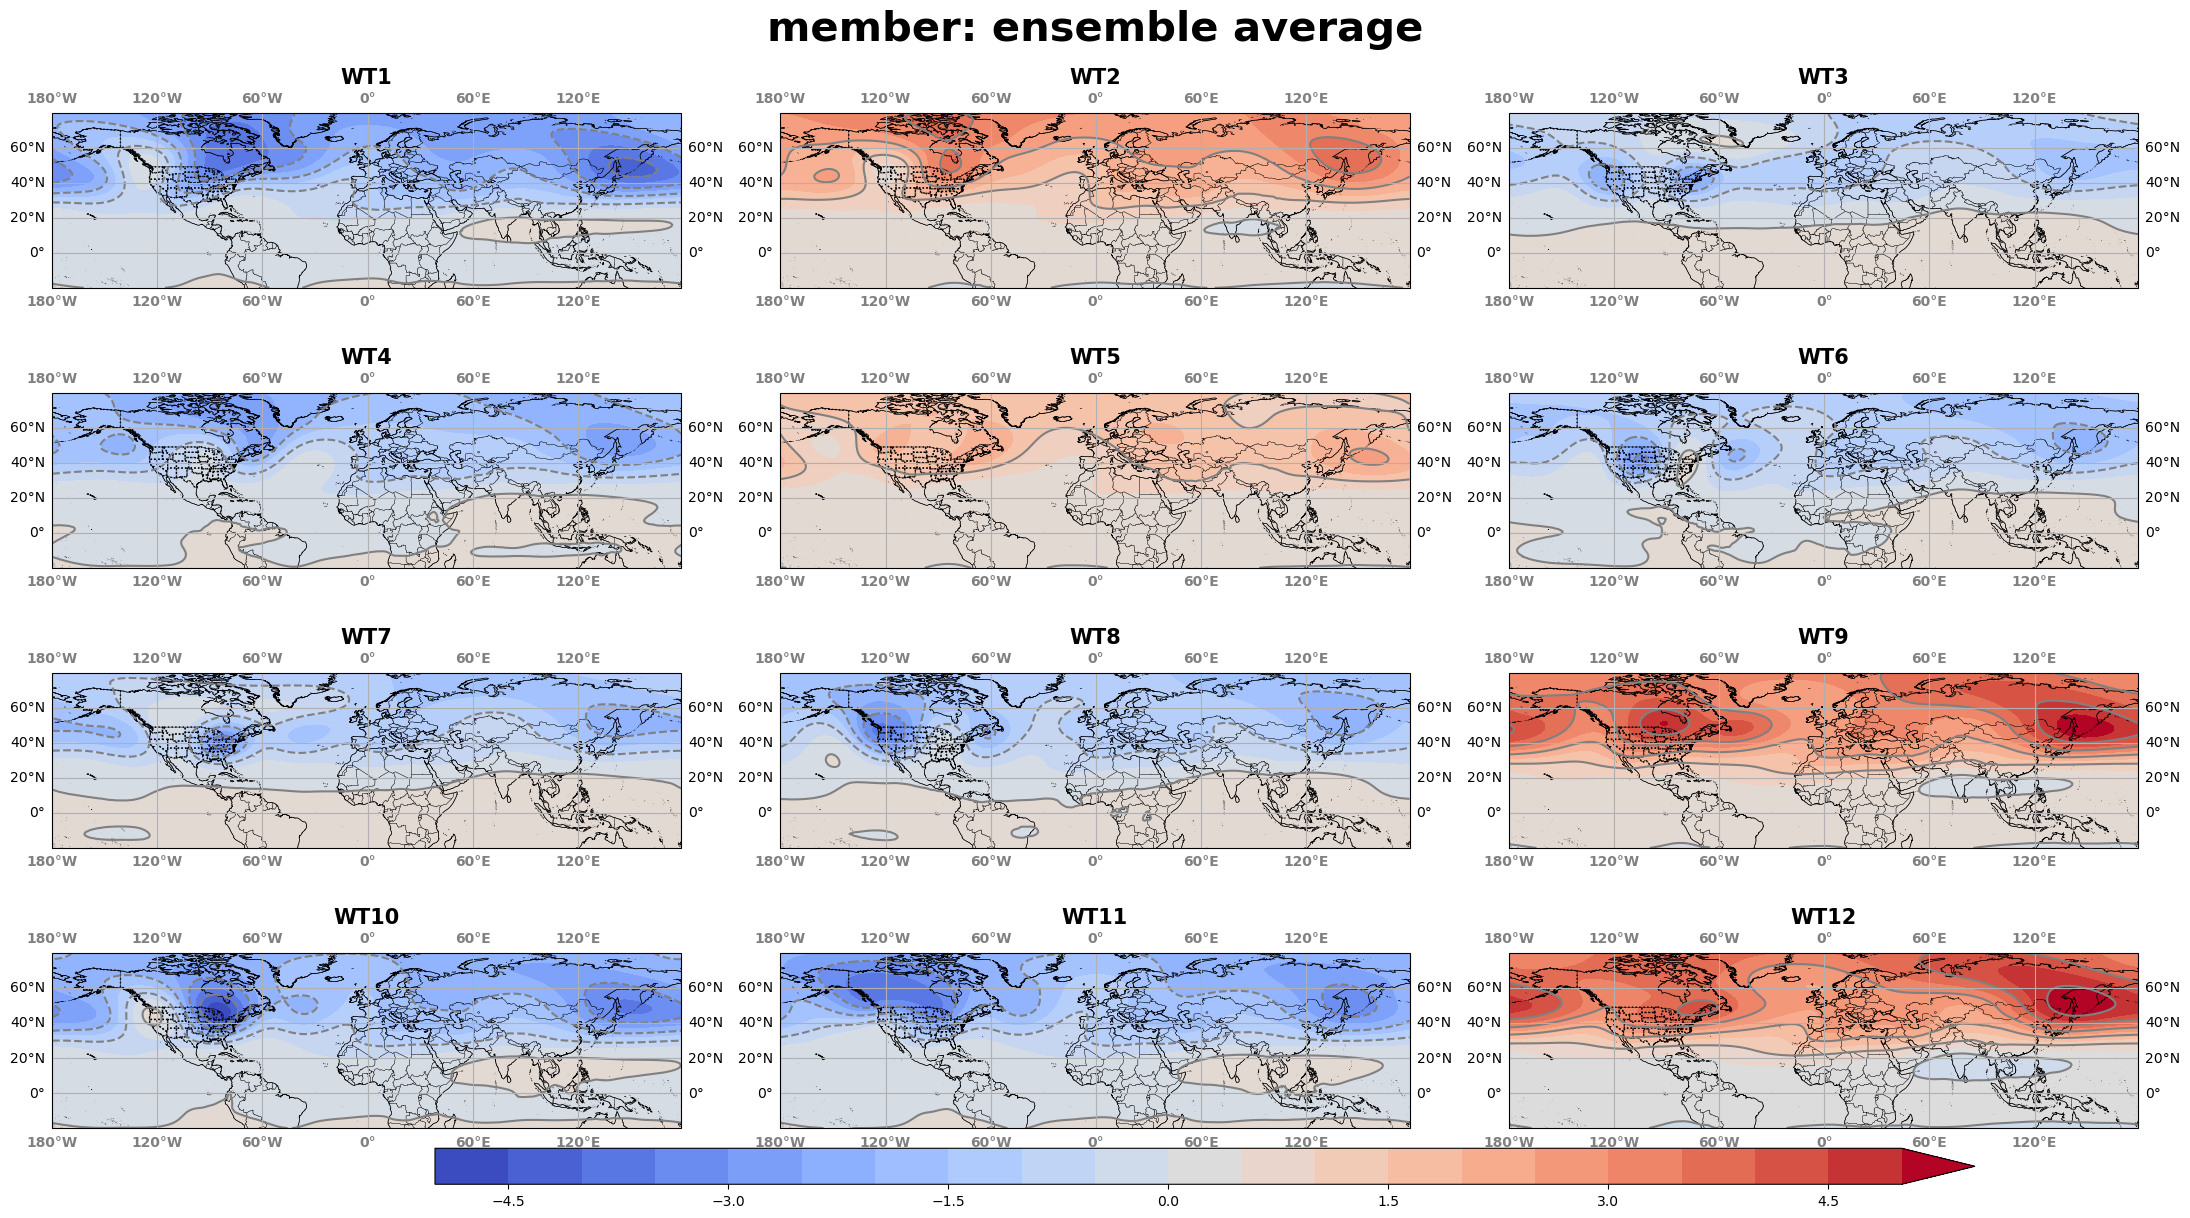

In [37]:
flnm_cli = dir_ecmwf + 'z500_clim_215day_12Z.nc'
with  xr.open_dataset(flnm_cli) as ds_cli:
    z500_cli = ds_cli.z500

n_lat = z500_cli.shape[0]
n_lon = z500_cli.shape[1]
n_mem = 51

for mem in range(1, n_mem+1,1):
    mem_s = str(mem).zfill(2)
    flnm_wt = dir_wt + 'z500_ano_mem' + mem_s + '.nc'
    #print(flnm_wt)
    
    with  xr.open_dataset(flnm_wt) as ds:
        z500_wt = ds.__xarray_dataarray_variable__
        if mem == 1:
            z500_avg = z500_wt.copy()
        else:
            z500_avg = z500_avg + z500_wt

plot_prec_12(z500_avg*100/n_mem, -5, 5, 21, 'coolwarm', 'horizontal', 'ensemble average');